<a href="https://colab.research.google.com/github/karenl7/AA548-spr2024/blob/dev/homework/hw1_starter_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pdb
import math

In [6]:
class DynUnicycle:

    def state_derivative(self, state, control):
        '''
        Computes x_dot where x_dot = f(x, u)
        Inputs:
            state     : A jax.numpy array of size (n,)
            control   : A jax.numpy array of size (m,)

        Output:
            state_derivative : A jax.numpy array of size (n,)
        '''
        x, y, theta, v = state
        w, a = control
        x_dot = v * jnp.cos(theta)
        y_dot = v * jnp.sin(theta)
        theta_dot = w
        v_dot = a
        state_derivative = jnp.array([x_dot, y_dot, theta_dot, v_dot])
        return state_derivative

    def euler_step(self, state, control, dt):
        '''
        Computes x(k+1) using euler integration
        Inputs:
            state     : A jax.numpy array of size (n,)
            control   : A jax.numpy array of size (m,)
            dt        : time step, a float

        Output:
            next_state : A jax.numpy array of size (n,)
        '''
        x, y, theta, v = state
        w, a = control
        x_k1 = x + v * jnp.cos(theta) * dt
        y_k1 = y + v * jnp.sin(theta) * dt
        theta_k1 = theta + w * dt
        v_k1 = v + a * dt
        state_derivative = jnp.array([x_k1, y_k1, theta_k1, v_k1])
        return state_derivative

    def analytic_step(self, state, control, dt):
        '''
        Computes x(k+1) using analytic expression from integration.
        Assumes zero-order hold
        Inputs:
            state     : A jax.numpy array of size (n,)
            control   : A jax.numpy array of size (m,)
            dt        : time step, a float

        Output:
            next_state : A jax.numpy array of size (n,)
        '''
        x, y, theta, v = state
        w, a = control
        
        # Handle ω ≈ 0 case with jax.numpy.where
        # Compute the next state for ω ≠ 0
        x_k1_no_zero = x + v/w * (jnp.sin(theta + w*dt) - jnp.sin(theta))
        y_k1_no_zero = y + v/w * (-jnp.cos(theta + w*dt) + jnp.cos(theta))
        
        # Compute the next state for ω ≈ 0 using the limit as ω → 0
        x_k1_zero = x + v * jnp.cos(theta) * dt
        y_k1_zero = y + v * jnp.sin(theta) * dt
        
        # Use jax.numpy.where to choose the correct next state based on ω
        x_k1 = jnp.where(jnp.abs(w) > 1e-10, x_k1_no_zero, x_k1_zero)
        y_k1 = jnp.where(jnp.abs(w) > 1e-10, y_k1_no_zero, y_k1_zero)
        
        # The rest of the state update remains the same
        theta_k1 = theta + w * dt
        v_k1 = v + a * dt
        
        return jnp.array([x_k1, y_k1, theta_k1, v_k1])

    def RK4_step(self, state, control, dt):
        '''
        Computes x(k+1) using Runge-Kutta integration.
        Assumes zero-order hold
        Inputs:
            state     : A jax.numpy array of size (n,)
            control   : A jax.numpy array of size (m,)
            dt        : time step, a float

        Output:
            next_state : A jax.numpy array of size (n,)
        '''
        k1 = self.state_derivative(state, control)
        k2 = self.state_derivative(state + (dt/2) * k1, control)
        k3 = self.state_derivative(state + (dt/2) * k2, control)
        k4 = self.state_derivative(state + dt * k3, control)
        next_state = state + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)
        return next_state

    def linearize_continuous_time_analytic(self, state, control):
        '''
        Linearizes the continuous time dynamics using analytic expression
        Inputs:
            state     : A jax.numpy array of size (n,)
            control   : A jax.numpy array of size (m,)

        Outputs:
            A : A jax.numpy array of size (n,n)
            B : A jax.numpy array of size (n,m)
            C : A jax.numpy array of size (n,1)
        '''
        x, y, theta, v = state
        w, a = control
        A = jnp.array([[0,0,-v*jnp.sin(theta), jnp.cos(theta)],
             [0,0,v*jnp.cos(theta), jnp.sin(theta)],
             [0,0,0,0],
             [0,0,0,0]])
        
        B = jnp.array([[0,0],
             [0,0],
             [1,0],
             [0,1]])
        C = - A @ state - B @ control + self.state_derivative(state, control)
        return A, B, C

def discrete_time_simulate(discrete_time_dyn, initial_state, control_sequence):
    '''
    Propgates states through discrete_time_dyn using control_sequence, starting at initial_state.
    Inputs:
        discrete_time_dyn : A function that takes in a state and control, and returns the next state
        initial_state     : A jax.numpy array of size (n,)
        control_sequence  : A sequence of control inputs. A jax.numpy array of size (T,m) where T is the control inputs

    Output:
        A sequence of states from executing the control sequence. A jax.numpy array of size (T+1, n).
    '''
    states = [initial_state]
    for control in control_sequence:
        next_state = discrete_time_dyn(states[-1], control)
        states.append(next_state)
    return jnp.array(states)

def linearize_autodiff(state_derivative, state, control):
    '''
    Linearizes the any dynamics using jax autodiff.
    Inputs:
        function_name: name of function to be linearized. Takes state and control as inputs.
        state     : A jax.numpy array of size (n,)
        control   : A jax.numpy array of size (m,)

    Outputs:
        A : A jax.numpy array of size (n,n)
        B : A jax.numpy array of size (n,m)
        C : A jax.numpy array of size (n,1)
    '''
    A = jax.jacfwd(state_derivative, argnums = 0)(state, control)
    B = jax.jacfwd(state_derivative, argnums = 1)(state, control)
    C = -jax.jacfwd(state_derivative, argnums = 0)(state, control) @ state - jax.jacfwd(state_derivative, argnums = 1)(state, control) @ control + state_derivative(state, control)
    return A, B, C


# Problem 1

The plotting code is provided below. But you need to fill out some functions first in order to run it.
- `state_derivative`
- `euler_step`
- `analytic_step`
- `RK4_step`
- `discrete_time_simulate`


In [7]:
# generating initial state and control sequence
initial_state = jnp.array([0, 0, jnp.pi/4, 2.])  # initial state, size [4,] array
def generate_control_sequence(dt, horizon=5):
    N = round(horizon / dt)
    w_sequence = jnp.sin(jnp.linspace(0, jnp.pi, N))  # w varies sinusoidally over time
    return jnp.stack([w_sequence, jnp.zeros(N)], 1)  # a is zero (constant speed), size [T, 2] array

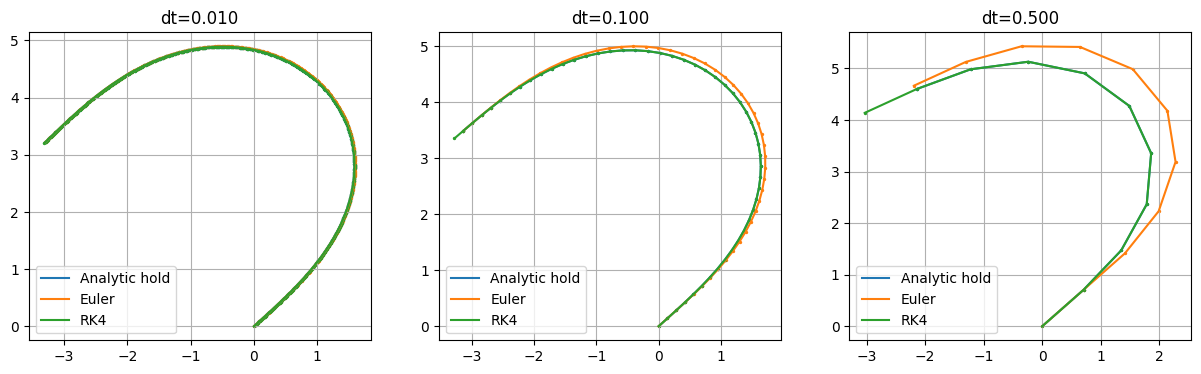

In [8]:
## Feel free to edit this code to tailor it to your implementation
unicycle = DynUnicycle()

plt.figure(figsize=(15,4))

dt_array = [0.01, 0.1, 0.5]

for (i,dt) in enumerate(dt_array):

    controls = generate_control_sequence(dt, 5)

    plt.subplot(1,3,i+1)
    traj = discrete_time_simulate(jax.jit(lambda s,c: unicycle.analytic_step(s,c,dt)), initial_state, controls)
    plt.plot(traj[:,0], traj[:,1], label="Analytic hold")
    plt.scatter(traj[:,0], traj[:,1], s=2)


    traj = discrete_time_simulate(jax.jit(lambda s,c: unicycle.euler_step(s,c,dt)), initial_state, controls)
    plt.plot(traj[:,0], traj[:,1], label="Euler")
    plt.scatter(traj[:,0], traj[:,1], s=2)

    traj = discrete_time_simulate(jax.jit(lambda s,c: unicycle.RK4_step(s,c,dt)), initial_state, controls)
    plt.plot(traj[:,0], traj[:,1], label="RK4")
    plt.scatter(traj[:,0], traj[:,1], s=2)

    plt.grid()
    plt.legend()

    plt.title("dt=%.3f"%dt)

import os

# Create directory if it doesn't exist
hw_dir = '../HW'
if not os.path.exists(hw_dir):
    os.makedirs(hw_dir)

# Save the figure
plt.savefig(os.path.join(hw_dir, 'HW1_problem1.png'))

# Problem 2

In [9]:
x0 = jnp.array([0., 0., jnp.pi/4, 2.])
u0 = jnp.array([0.1, 1.])

### 2(c)  

You need to fill in code for `linearize_autodiff` function.
And also `linearize_continuous_time_analytic` to test your analytic solution.

Some code to print out values from linearizing the continuous time dynamics about a point

In [10]:
## Feel free to edit this code to tailor it to your implementation

decimal_places = 2

A, B, C = unicycle.linearize_continuous_time_analytic(x0, u0)
print("Linearization from analytic expression")
print("A\n", round(A, decimal_places))
print("B\n", round(B, decimal_places))
print("C\n", round(C, decimal_places))

print("\n\n")

A, B, C = linearize_autodiff(unicycle.state_derivative, x0, u0)
print("Linearization using autodiff on continuous time dynamics")
print("A\n", round(A, decimal_places))
print("B\n", round(B, decimal_places))
print("C\n", round(C, decimal_places))


Linearization from analytic expression
A
 [[ 0.    0.   -1.41  0.71]
 [ 0.    0.    1.41  0.71]
 [ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]]
B
 [[0 0]
 [0 0]
 [1 0]
 [0 1]]
C
 [ 1.11 -1.11  0.    0.  ]



Linearization using autodiff on continuous time dynamics
A
 [[ 0.    0.   -1.41  0.71]
 [ 0.    0.    1.41  0.71]
 [ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]]
B
 [[0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]]
C
 [ 1.11 -1.11  0.    0.  ]


### 2(d)

Some code to print out values from linearizing the zero-order hold dynamics about a point

In [11]:
## Feel free to edit this code to tailor it to your implementation

decimal_places = 2

A, B, C = linearize_autodiff(lambda s,c: unicycle.analytic_step(s, c, dt), x0, u0)
print("Linearization using autodiff on analytic step ")
print("A\n", round(A, decimal_places))
print("B\n", round(B, decimal_places))
print("C\n", round(C, decimal_places))



A, B, C = linearize_autodiff(lambda s,c: unicycle.RK4_step(s, c, dt), x0, u0)
print("Linearization using autodiff on RK4 step ")
print("A\n", round(A, decimal_places))
print("B\n", round(B, decimal_places))
print("C\n", round(C, decimal_places))


Linearization using autodiff on analytic step 
A
 [[ 1.          0.         -0.71999997  0.34      ]
 [ 0.          1.          0.69        0.35999998]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
B
 [[-0.17999999  0.        ]
 [ 0.17        0.        ]
 [ 0.5         0.        ]
 [ 0.          0.5       ]]
C
 [ 0.59 -0.56  0.    0.  ]
Linearization using autodiff on RK4 step 
A
 [[ 1.          0.         -0.82        0.34      ]
 [ 0.          1.          0.77        0.35999998]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
B
 [[-0.21        0.09      ]
 [ 0.19999999  0.09      ]
 [ 0.5         0.        ]
 [ 0.          0.5       ]]
C
 [ 0.65999997 -0.63        0.          0.        ]


TypeError: state_derivative() missing 2 required positional arguments: 'state' and 'control'

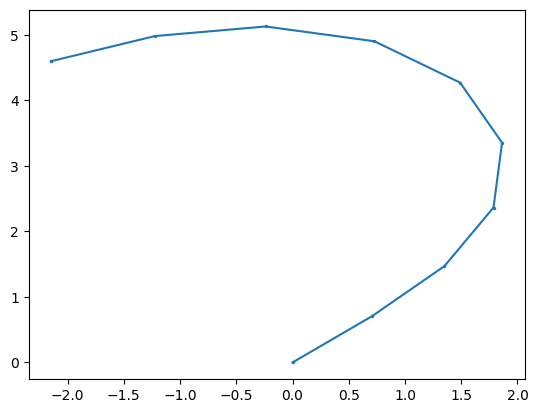

In [12]:
traj = discrete_time_simulate(jax.jit(lambda s,c: unicycle.analytic_step(s,c,dt)), initial_state, controls)
plt.plot(traj[:,0], traj[:,1], label="Analytic hold")
plt.scatter(traj[:,0], traj[:,1], s=2)
jax.vmap(jax.jacobian(unicycle.state_derivative()), in_axes=[0])(controls)

In [ ]:
import numpy as np
def foo(x):
    a, b = x
    return jnp.where(a<0, -2*a, 6*b)

N = 10
batched_inputs = jnp.array(np.random.randn(N,2))

jax.vmap(jax.jacobian(foo), in_axes=[0])(batched_inputs)

Array([[-2.,  0.],
       [ 0.,  6.],
       [-2.,  0.],
       [-2.,  0.],
       [ 0.,  6.],
       [-2.,  0.],
       [-2.,  0.],
       [-2.,  0.],
       [ 0.,  6.],
       [-2.,  0.]], dtype=float32)

## Problem 3

In [ ]:
def cart_pole(state, control):
    '''Cart-pole continuous-time dynamics'''
    x, theta, x_dot, theta_dot = state
    fx = control
    x_dotdot = 1/(1+jnp.sin(theta)**2)*(fx + jnp.sin(theta)*(theta_dot ** 2 + 9.81 * jnp.cos(theta)))
    theta_dotdot = 1/(1+jnp.sin(theta)**2)*(-fx*jnp.cos(theta)-theta_dot**2*jnp.cos(theta) * jnp.sin(theta)-2*9.81*jnp.sin(theta))
    print(x_dot.shape, theta_dot.shape, x_dotdot.shape, theta_dotdot.shape)
    state_dot = jnp.array([[x_dot], [theta_dot], [x_dotdot], [theta_dotdot]])
    return state_dot


def cart_pole_linearized(state, control, state_eq, control_eq):
    '''Linearize cart-pole continuous-time dynamics about equilibrium point'''
    A = jax.jacfwd(cart_pole, argnums = 0)(state, control)
    B = jax.jacfwd(cart_pole, argnums = 1)(state, control)
    delta_state = state - state_eq
    delta_control = control - control_eq
    f = cart_pole(state_eq, control_eq) + A @ delta_state + B @ delta_control
    return f


def linearization_error(state, control, state_eq, control_eq):
    '''Computes linearization error'''
    print(state.shape, control.shape, state_eq.shape, control_eq.shape)
    flin = cart_pole_linearized(state, control, state_eq, control_eq)
    f = cart_pole(state, control)
    print(f.shape, flin.shape)
    error = np.linalg.norm(f - flin)
    return error



In [16]:
## Feel free to edit this code to tailor it to your implementation

# x, theta, xdot, thetadot
state_eq = jnp.array([0., jnp.pi, 0.0, 0.0])
control_eq = jnp.zeros(1)
states = jnp.array([[0,0.99*jnp.pi,0,0],
                    [0,0.9*jnp.pi,0,0],
                    [0,0.85*jnp.pi,0,0],
                    [0,0.5*jnp.pi,0,0],
                    [0,0,0,0],
                    [1,jnp.pi,0,0]])
controls = jnp.array([[-0.],
                      [-10.],
                      [0.],
                      [0.],
                      [0.],
                      [10.]])

errors = jax.vmap(linearization_error, in_axes=[0, 0, None, None])(states, controls, state_eq, control_eq)


(4,) (1,) (4,) (1,)


ValueError: All input arrays must have the same shape.

In [ ]:
## Feel free to edit this code to tailor it to your implementation

for i, e in enumerate(errors):
    print(f"State = {jnp.around(states[i], decimals=3)}^T")
    print(f"Input = {jnp.around(controls[i], decimals=3)}")
    print("Linearization error = %.3f"%e)
    print("Norm of f(x,u) = %.3f\n"%jnp.linalg.norm(cart_pole(states[i], controls[i])))

TypeError: 'NoneType' object is not iterable